In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import requests
import json
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
pd.set_option('display.max_rows',100)

In [7]:
def createDayDataframe(filename):
    path = "tongsdata/"
    filedate = filename.split(".")[0].split("-")

    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())

    #  Create X DataFrame
    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T

    #  Create y DataFrame
    energyBalanceFilename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(filedate[0], filedate[1], filedate[2]) #change due to json filename
    energyBalance = pd.read_csv(path + energyBalanceFilename, delimiter=";")

    energyBalance_DF = pd.DataFrame(index=energyBalance.iloc[:-1,0].apply(lambda x: x[2:-1]))
    energyBalance_DF['PV Power Generation'] = energyBalance['PV power generation / Mean values [W]  '].values[:-1]
    energyBalance_DF = energyBalance_DF[energyBalance_DF != ' ']
    energyBalance_DF = energyBalance_DF.dropna()

    #  Join X y DataFrame
    data = todayData_DF.join(energyBalance_DF)
    return data

def cleanDataframe(masterDF):
    masterData_cleaned = masterDF.reset_index()
    masterData_cleaned = masterData_cleaned.rename(columns={'index': 'time_of_day'})
    masterData_cleaned = masterData_cleaned[masterData_cleaned['PV Power Generation'].notna()]
    #masterData_cleaned['month'] = masterData_cleaned['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    masterData_cleaned['cloudCover'] = masterData_cleaned['cloudCover'].fillna(value=masterData_cleaned['cloudCover'].mean())
    masterData_cleaned['PV Power Generation'] = masterData_cleaned['PV Power Generation'].apply(lambda x: x.replace(",", "")).astype('float')
    return masterData_cleaned

def featureEngineering(masterDF):
    masterDF = masterDF.drop(columns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType'])
    #masterDF = pd.get_dummies(masterDF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
    masterDF = pd.get_dummies(masterDF, columns=['time_of_day'])
    return masterDF

    

### รันแค่ครั้งเดียวเพื่อ fit model

In [8]:
import os
import pandas as pd
import json
import datetime

files = os.listdir("tongsdata/")

#files.remove(".DS_Store")
files.remove("energyBalance")

masterData = pd.DataFrame()

for file in files:
    r = createDayDataframe(file).loc['06:30':'18:00']
    #print(file, r.shape)
    masterData = pd.concat([masterData, r], axis=0)

masterData = cleanDataframe(masterData)
masterData = featureEngineering(masterData)

features = list(masterData.drop(columns=['PV Power Generation']).columns)

masterData = masterData.dropna()

X = masterData.drop(columns=['PV Power Generation']).astype('float').values
y = masterData['PV Power Generation'].astype('float').values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

training_features, testing_features, training_target, testing_target = train_test_split(X, y)

# Average CV score on the training set was:-91867.4890210794
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=1, min_samples_split=7, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

#from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
#print(mean_squared_error(testing_target, results), 
#mean_absolute_error(testing_target, results), 
#r2_score(testing_target, results))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [9]:
def clean1(date):
    date = date.split("-")
    path = "tongsdata/"
    filename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(date[0], date[1], date[2])
    rawdata=pd.read_csv(path + filename, delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=date[0]+date[1]+date[2]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

In [36]:
def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))*100

In [41]:
def aape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return (np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))*100

In [44]:
def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))*100

Start to test here

In [80]:
def predictgen(predict_date):
    path = "tongsdata/"
    filename = predict_date.replace("_",'-') + '.json'
    
    with open(path + filename, 'r', encoding='utf-8') as fin:
        data_json = json.loads(fin.read())
    
    todayData = {time: data_json[time]['currently'] for time in data_json}
    todayData_DF = pd.DataFrame(todayData).T
    
    todayData_DF.index.names=['time_of_day']
    todayData_DF = todayData_DF.loc['06:30':'18:00']
    todayData_DF = todayData_DF.reset_index()
    #todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
    
    todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
    #todayData_DF['cloudCover'] = 0.19
    dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType']
    for i in dropcolumns:
        if i in todayData_DF.columns:
            todayData_DF = todayData_DF.drop(columns=[i])
    #todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
    todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day'])

    masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
    for i in range(len(masterData_for_predict.columns)) : #drop power balance
        if masterData_for_predict.columns[i] not in todayData_DF.columns:
            todayData_DF.insert(i, masterData.columns[i+1], 0)
    missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index
    
    col = ['apparentTemperature','cloudCover','dewPoint','humidity','temperature','visibility','windSpeed']
    for col in todayData_DF:
        todayData_DF[col] = pd.to_numeric(todayData_DF[col], errors='coerce')
    if todayData_DF.isna().loc[0,'uvIndex']:
        todayData_DF.loc[0,'uvIndex'] = 0
    todayData_DF=todayData_DF.interpolate(limit_direction='both')
    
    first_predict = todayData_DF.astype('float').values
    
    results_first_predict = exported_pipeline.predict(first_predict)
    results_first_predict = np.array(results_first_predict).tolist()
    for i in range(25):
        results_first_predict.insert(0,0.0)
    for j in range (24):
        results_first_predict.append(0.0)
    return results_first_predict

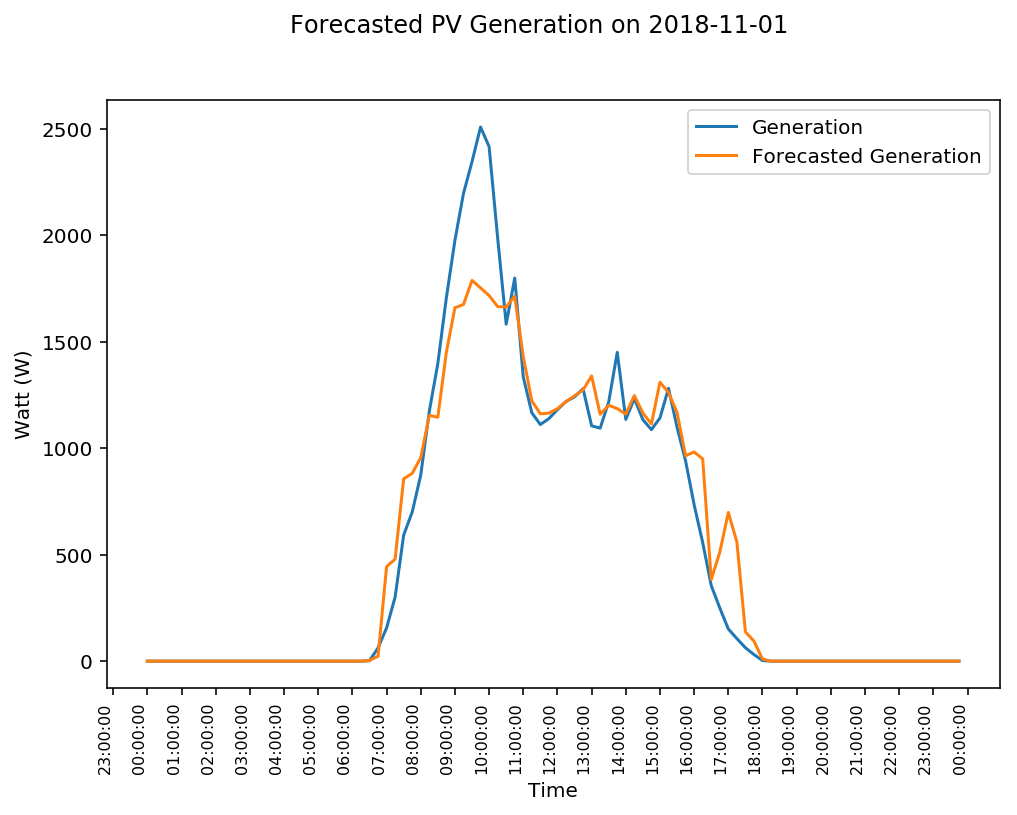

In [83]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')


df[['Generation' ,'Forecasted Generation']].plot(ax = ax, x_compat=True)
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation on ' + date)
plt.show()

In [221]:
date = "2018-11-30"
df = clean1(date)

In [222]:
df["Forecasted Generation"] = predictgen(date)

In [223]:
df1 = df[['Generation','Forecasted Generation']]
df1 = df1.rename(columns={'Generation': 'Real Generation'})

In [224]:
df1["SMAPE"] = 0

for index, row in df1.iterrows():
    error = smape(row["Real Generation"], row["Forecasted Generation"])
    df1.loc[index,"SMAPE"] = error

In [225]:
each_day_error = df1.loc[date +' 06:30:00':date +' 18:00:00','SMAPE'].mean()

#df5 = pd.DataFrame()
df5 = df5.append({"Date": date, "MAAPE": each_day_error}, ignore_index=True)
df5

,Date,MAAPE
0,2018-11-01,28.857306
1,2018-11-03,34.065300
2,2018-11-04,20.167673
3,2018-11-05,19.026580
4,2018-11-06,26.762923
5,2018-11-07,20.962945
6,2018-11-08,24.832573
7,2018-11-09,39.723949
8,2018-11-10,20.843370
9,2018-11-11,23.336041


In [226]:
df5.sort_values(by="MAAPE")

,Date,MAAPE
27,2018-11-30,14.177886
21,2018-11-24,14.331774
23,2018-11-26,15.614958
12,2018-11-14,16.333532
25,2018-11-28,17.618609
20,2018-11-23,18.384476
3,2018-11-05,19.026580
18,2018-11-21,19.732072
2,2018-11-04,20.167673
19,2018-11-22,20.428442


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


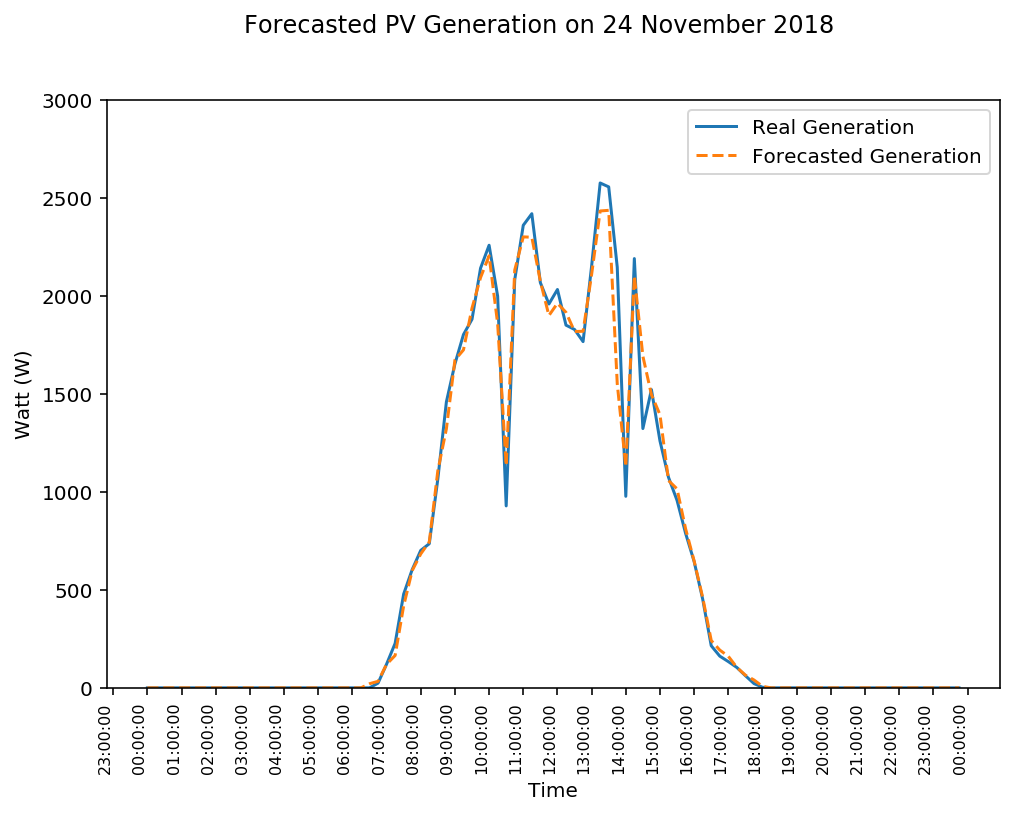

In [16]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')


df1['Real Generation'].plot(ax = ax, x_compat=True)
df1['Forecasted Generation'].plot(ax = ax, x_compat=True, linestyle='--')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
ax.set_ylim(ymin=0, ymax=3000)
plt.xticks(rotation='vertical', fontsize = 8)
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation on 24 November 2018') #change date
legend = ax.legend(loc='best')
#plt.savefig('FPV_24Nov.png')
plt.show()

In [561]:
df2

,MAAPE
Date,
2018-11-01,28.867601
2018-11-03,28.271282
2018-11-04,18.667655
2018-11-05,12.769683
2018-11-06,29.178154
2018-11-07,20.070027
2018-11-08,20.912153
2018-11-09,42.419775
2018-11-10,20.866775


In [506]:
df2.to_csv('MAAPE_Nov.csv')

In [542]:
df2.max()

MAAPE    42.419775
dtype: float64

In [430]:
df2["Date"] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2.set_index('Date', inplace=True)
df2

,level_0,index,MAAPE
Date,,,
2018-11-01,0,0,28.867601
2018-11-03,1,1,28.271282
2018-11-04,2,2,18.667655
2018-11-05,3,3,12.769683
2018-11-06,4,4,29.178154
2018-11-07,5,5,20.070027
2018-11-08,6,6,20.912153
2018-11-09,7,7,42.419775
2018-11-10,8,8,20.866775


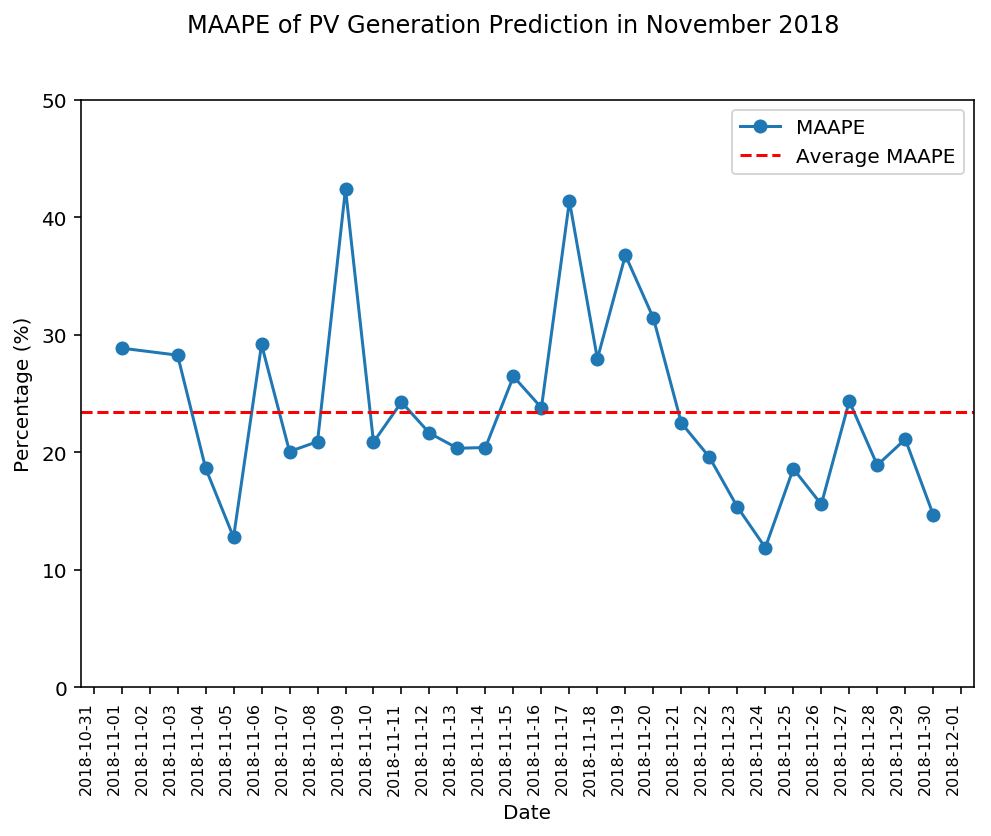

In [497]:
fig, ax = plt.subplots()

day = mdates.DayLocator(interval = 1)
myFmt = mdates.DateFormatter('%Y-%m-%d')

df2["MAAPE"].plot(ax = ax, x_compat=True ,marker='o')
#Then tick and format with matplotlib:
y_mean = df2["MAAPE"].mean()
plt.axhline(y=y_mean, label='Average MAAPE', linestyle='--', color='red')

ax.xaxis.set_major_locator(day)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
ax.set_ylim(ymin=0, ymax=50)
legend = ax.legend(loc='upper right')
plt.ylabel('Percentage (%)')
plt.suptitle('MAAPE of PV Generation Prediction in November 2018')


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.savefig('MAAPE_Nov.png')
#plt.show()

In [489]:
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)

Current size: [6.0, 4.0]


In [503]:
df2["MAAPE"].mean()
df2["MAAPE"].std()

7.620925420247845

วันที่ 3 ผิดเยอะเนื่องจาก uvIndex ที่เรียกมาเป็นNaNเยอะ

วันที่ 4 ผิดช่วงที่ uvIndex เป็น NaN

1,2,3,4,6,9,10,17,19,25

Text(0, 0.5, 'Watt (W)')

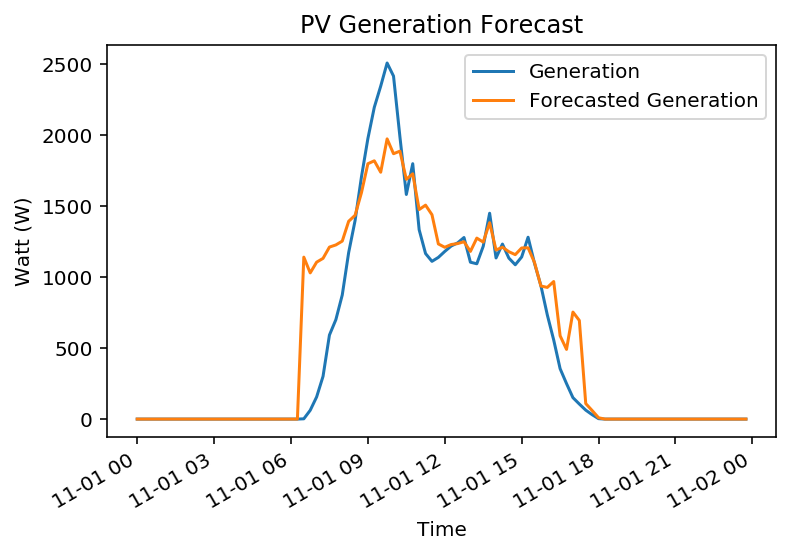

In [31]:
df[['Generation' ,'Forecasted Generation']].plot(kind='line', title='PV Generation Forecast').set_ylabel('Watt (W)')

In [65]:
predict_date = '2018-11-17'
path = "tongsdata/"
filename = predict_date.replace("_",'-') + '.json'

with open(path + filename, 'r', encoding='utf-8') as fin:
    data_json = json.loads(fin.read())

todayData = {time: data_json[time]['currently'] for time in data_json}
todayData_DF = pd.DataFrame(todayData).T

todayData_DF.index.names=['time_of_day']
todayData_DF = todayData_DF.loc['06:30':'18:00']
todayData_DF = todayData_DF.reset_index()
#todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)

todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
#todayData_DF['cloudCover'] = 0.19

dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure','precipType']
for i in dropcolumns:
    if i in todayData_DF.columns:
        todayData_DF = todayData_DF.drop(columns=[i])
#todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])
todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day'])

masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
for i in range(len(masterData_for_predict.columns)) : #drop power balance
    if masterData_for_predict.columns[i] not in todayData_DF.columns:
        todayData_DF.insert(i, masterData.columns[i+1], 0)
missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index

col = ['apparentTemperature','cloudCover','dewPoint','humidity','temperature','visibility','windSpeed']
for col in todayData_DF:
    todayData_DF[col] = pd.to_numeric(todayData_DF[col], errors='coerce')
#todayData_DF=todayData_DF.interpolate(limit_direction='both')

In [52]:
if todayData_DF.isna().loc[0,'uvIndex']:
    todayData_DF.loc[0,'uvIndex'] = 0

a


In [220]:
todayData_DF=todayData_DF.interpolate(limit_direction='both')

In [66]:
todayData_DF

,apparentTemperature,cloudCover,dewPoint,humidity,temperature,uvIndex,visibility,windSpeed,time_of_day_06:30,time_of_day_06:45,...,time_of_day_15:45,time_of_day_16:00,time_of_day_16:15,time_of_day_16:30,time_of_day_16:45,time_of_day_17:00,time_of_day_17:15,time_of_day_17:30,time_of_day_17:45,time_of_day_18:00
0,86.60,0.19,77.03,0.91,80.03,0,4.92,2.66,1,0,...,0,0,0,0,0,0,0,0,0,0
1,86.59,0.19,76.48,0.88,80.29,0,4.52,2.32,0,1,...,0,0,0,0,0,0,0,0,0,0
2,86.54,0.19,75.91,0.86,80.55,0,4.12,1.99,0,0,...,0,0,0,0,0,0,0,0,0,0
3,88.92,0.25,76.39,0.84,81.64,0,4.18,1.98,0,0,...,0,0,0,0,0,0,0,0,0,0
4,91.38,0.31,76.85,0.83,82.73,1,4.25,1.98,0,0,...,0,0,0,0,0,0,0,0,0,0
5,93.80,0.38,77.29,0.81,83.82,1,4.31,1.98,0,0,...,0,0,0,0,0,0,0,0,0,0
6,96.19,0.44,77.72,0.79,84.91,1,4.38,1.99,0,0,...,0,0,0,0,0,0,0,0,0,0
7,98.07,0.44,78.25,0.79,85.63,1,4.65,1.17,0,0,...,0,0,0,0,0,0,0,0,0,0
8,99.99,0.44,78.78,0.78,86.35,2,4.93,0.68,0,0,...,0,0,0,0,0,0,0,0,0,0
9,101.95,0.44,79.31,0.78,87.07,2,5.20,1.10,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
first_predict = todayData_DF.astype('float').values

results_first_predict = exported_pipeline.predict(first_predict)
results_first_predict = np.array(results_first_predict).tolist()
for i in range(25):
    results_first_predict.insert(0,0.0)
for j in range (24):
    results_first_predict.append(0.0)
results_first_predict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.606333333333332,
 48.00633333333332,
 69.15816666666665,
 174.016,
 233.28599999999997,
 360.1251666666667,
 290.00100000000003,
 744.4014999999995,
 528.9105000000001,
 768.4571666666666,
 945.0736666666666,
 731.5323333333332,
 749.6646666666668,
 696.5938333333331,
 1443.3718333333336,
 930.2751666666669,
 821.3473333333335,
 897.1423333333332,
 524.9839999999998,
 498.40233333333316,
 485.8895,
 467.1674999999998,
 493.57133333333326,
 639.631666666667,
 625.0058333333336,
 543.1531666666668,
 561.9396666666667,
 529.3011666666666,
 456.14649999999995,
 506.43050000000005,
 597.3295000000002,
 633.452,
 663.0454999999998,
 668.5205000000001,
 706.9243333333335,
 586.1781666666666,
 558.1668333333333,
 534.4153333333334,
 322.3651666666667,
 262.45133333333337,
 122.90900000000003,
 77.69949999999999,
 22.776166666666665,
 11.664166

In [223]:
from sklearn.feature_selection import SelectFromModel
featuresImportance = pd.DataFrame()
featuresImportance['Feature Name'] = features
featuresImportance['Importance'] = exported_pipeline.feature_importances_

featuresImportance.sort_values('Importance', ascending=False)

,Feature Name,Importance
5,uvIndex,0.517258
4,temperature,0.075463
3,humidity,0.071981
1,cloudCover,0.052690
0,apparentTemperature,0.046353
2,dewPoint,0.039019
7,windSpeed,0.036749
6,visibility,0.028757
53,time_of_day_17:45,0.019669
52,time_of_day_17:30,0.014575


In [536]:
result = pd.DataFrame()
result['Real Generation'] = testing_target
result['Forecasted Generation'] = results
result['MAAPE'] = 0
for index, row in result.iterrows():
    error = maape(row["Real Generation"], row["Forecasted Generation"])
    result.loc[index,'MAAPE'] = error
result

,Real Generation,Forecasted Generation,MAAPE
0,115.0,566.477667,132.138108
1,3.0,4.716500,51.970235
2,405.0,321.094667,20.428370
3,1290.0,1666.397167,28.389924
4,1607.0,1751.908667,8.993019
5,329.0,153.643833,48.969580
6,637.0,596.132667,6.406813
7,2189.0,2129.923333,2.698142
8,19.0,99.547833,133.914615
9,2567.0,2071.565000,19.065732


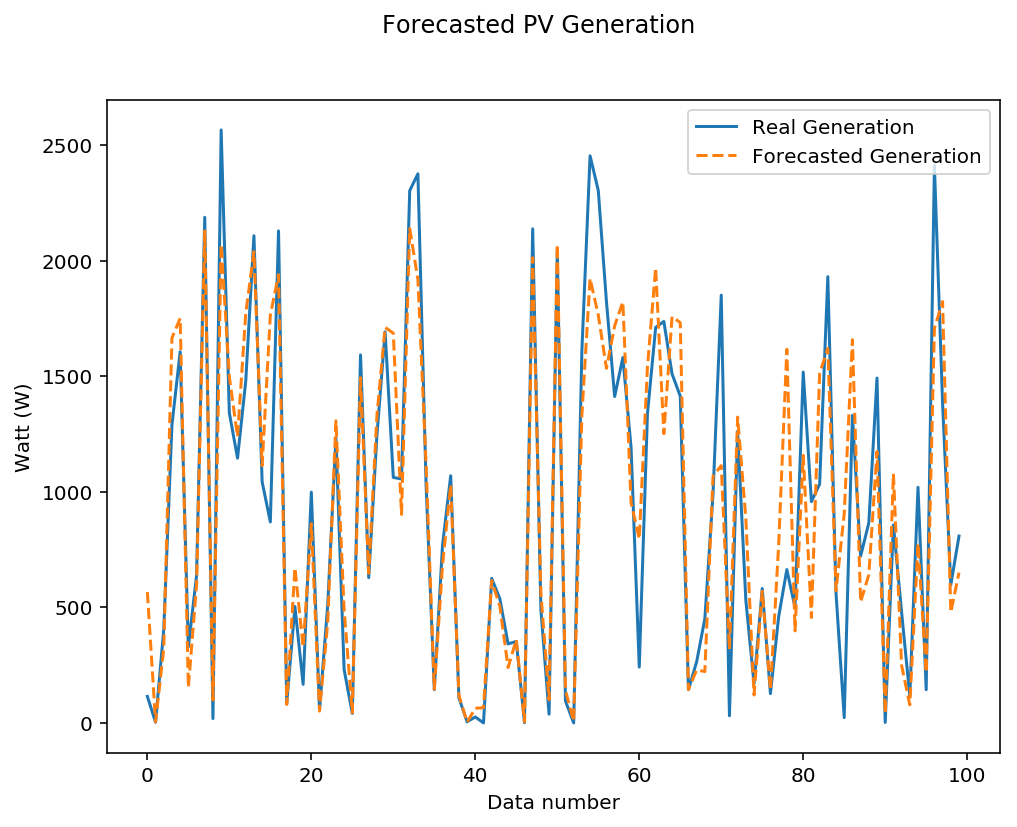

In [537]:
fig, ax = plt.subplots()

result['Real Generation'][0:100].plot(ax = ax, x_compat=True)
result['Forecasted Generation'][0:100].plot(ax = ax, x_compat=True, linestyle='--')
#Then tick and format with matplotlib:
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
#fig.autofmt_xdate()
#plt.xticks(rotation='vertical', fontsize = 8)
plt.xlabel('Data number')
plt.ylabel('Watt (W)')
plt.suptitle('Forecasted PV Generation')
legend = ax.legend(loc='best')
plt.savefig('Train.png')
plt.show()

In [550]:
result["MAAPE"].mean()

32.75776623074684

In [2]:
df2 = pd.read_csv("MAAPE_Nov.csv")

df2["Date"] = pd.to_datetime(df2["Date"])

df2.set_index("Date",inplace=True)

In [3]:
df2

,MAAPE
Date,
2018-11-01,28.867601
2018-11-03,28.271282
2018-11-04,18.667655
2018-11-05,12.769683
2018-11-06,29.178154
2018-11-07,20.070027
2018-11-08,20.912153
2018-11-09,42.419775
2018-11-10,20.866775


In [23]:
df2.sort_values(by=['MAAPE'])

,MAAPE
Date,
2018-11-24,11.889151
2018-11-05,12.769683
2018-11-30,14.691441
2018-11-23,15.356877
2018-11-26,15.574482
2018-11-25,18.606947
2018-11-04,18.667655
2018-11-28,18.906804
2018-11-22,19.598673


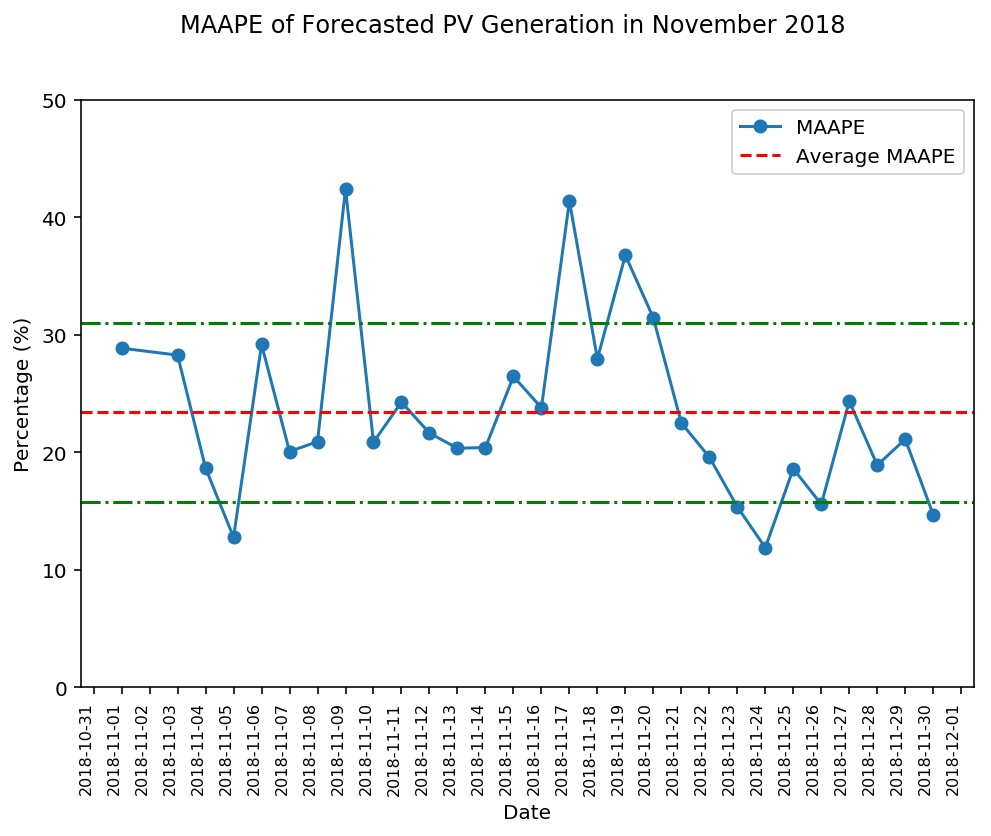

In [5]:
fig, ax = plt.subplots()

day = mdates.DayLocator(interval = 1)
myFmt = mdates.DateFormatter('%Y-%m-%d')

df2["MAAPE"].plot(ax = ax, x_compat=True ,marker='o')
#Then tick and format with matplotlib:
y_mean = df2["MAAPE"].mean()
y_std = df2["MAAPE"].std()
plt.axhline(y=y_mean, label='Average MAAPE', linestyle='--', color='red')
plt.axhline(y=y_mean - y_std, linestyle='-.', color='green')
plt.axhline(y=y_mean + y_std, linestyle='-.', color='green')


ax.xaxis.set_major_locator(day)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xticks(rotation='vertical', fontsize = 8)
ax.set_ylim(ymin=0, ymax=50)
legend = ax.legend(loc='upper right')
plt.ylabel('Percentage (%)')
plt.suptitle('MAAPE of Forecasted PV Generation in November 2018')


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.savefig('MAAPE_Nov1.png')
#plt.show()